https://forms.gle/Lq3egSoktmFu9jX37

In [2]:
from sklearn.datasets import load_iris

In [3]:
iris = load_iris()

In [4]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
import pandas

In [9]:
data = pandas.DataFrame(iris['data'], columns=iris['feature_names'])

In [10]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [11]:
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [13]:
iris['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
data_scaled = data / data.std()
data_scaled.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,7.056602,7.014384,2.128819,1.573438
std,1.000000,1.000000,1.000000,1.000000
min,5.192822,4.588563,0.566477,0.131193
25%,6.158928,6.423988,0.906362,0.393578
50%,7.004272,6.882845,2.464173,1.705505
75%,7.728851,7.571129,2.889030,2.361468
max,9.540301,10.094839,3.908688,3.279817


In [15]:
from sklearn.cluster import KMeans

In [17]:
inertias = [KMeans(n_clusters=k).fit(data_scaled).inertia_ for k in range(1, 5)]

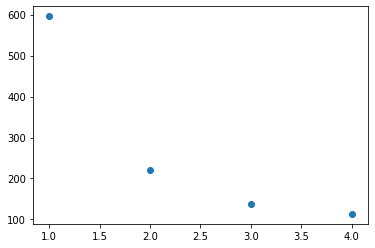

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(range(1, 5), inertias)

In [19]:
from sklearn.decomposition import PCA

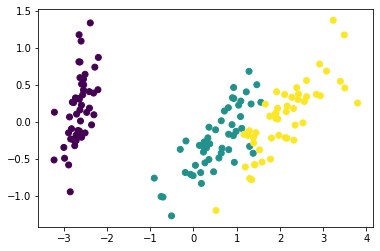

In [23]:
plt.scatter(*PCA(n_components=2).fit_transform(data).T, c=iris['target'])

In [24]:
import pystan

In [64]:
soft_k_means_code = """
data {
  int<lower=1> D;
  int<lower=0> N;
  int<lower=1> K;
  vector[D] y[N];
}
transformed data {
  real<upper=0> neg_log_K;
  neg_log_K = -log(K);
}
parameters {
  vector[D] mu[K];
}
transformed parameters {
  real<upper=0> soft_z[N, K];
  for (n in 1:N)
    for (k in 1:K)
      soft_z[n, k] = neg_log_K - 0.5*dot_self(mu[k] - y[n]);
}
model {
  for (k in 1:K)
    mu[k] ~ normal(5, 1e5);

  for (n in 1:N)
    target += log_sum_exp(soft_z[n]);
}
"""
iris_data = {'N': data_scaled.shape[0],
             'D': data_scaled.shape[1],
             'K': 3,
             'y': data_scaled}

In [65]:
model = pystan.StanModel(model_code=soft_k_means_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b70fe10847289112dfb6f8d79526d8a6 NOW.


In [66]:
fit = model.sampling(data=iris_data, iter=4000, chains=1)

In [67]:
sim_data = fit.extract(['mu', 'soft_z'])

In [68]:
sim_data['mu'].shape

(2000, 3, 4)

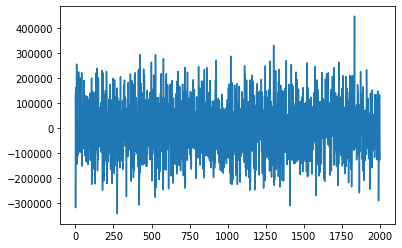

In [69]:
plt.plot(sim_data['mu'][:,0,0])

In [70]:
KMeans(n_clusters=3).fit(data_scaled).cluster_centers_

array([[7.00655008, 6.13395667, 2.47539551, 1.85402481],
       [6.0454109 , 7.86479734, 0.82818867, 0.32273398],
       [8.18877966, 7.10251008, 3.12164721, 2.5875662 ]])

In [71]:
sim_data['mu'].mean(axis=0)

array([[3.07915309e+03, 1.55289538e+03, 7.93733996e+02, 2.87792641e+03],
       [6.08946563e+00, 7.74163136e+00, 9.22751640e-01, 4.13308254e-01],
       [7.59368370e+00, 6.61282019e+00, 2.79863102e+00, 2.21843431e+00]])

In [72]:
sim_data['mu'].std(axis=0)

array([[1.02513524e+05, 1.01264876e+05, 1.00842191e+05, 9.89156178e+04],
       [1.38577680e-01, 1.58806953e-01, 1.46022679e-01, 1.44015375e-01],
       [1.09418734e-01, 1.03748797e-01, 9.69786331e-02, 1.05168283e-01]])

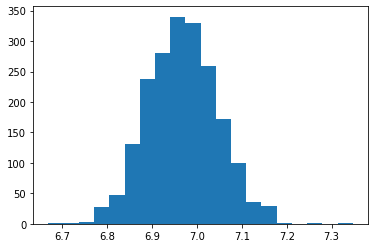

In [45]:
plt.hist(sim_data['mu'][:,2,1], bins=20)
None

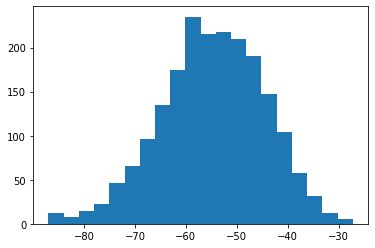

In [48]:
plt.hist(sim_data['soft_z'][:,0,0], bins=20)
None

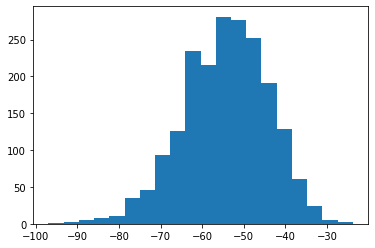

In [49]:
plt.hist(sim_data['soft_z'][:,0,1], bins=20)
None

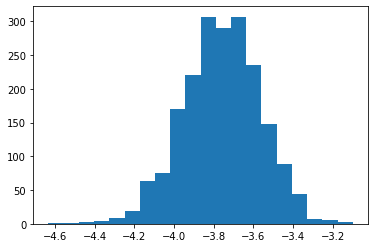

In [50]:
plt.hist(sim_data['soft_z'][:,0,2], bins=20)
None

In [51]:
kinda_log_like = [sim_data['soft_z'][:,0,i].mean() for i in range(3)]

In [52]:
kinda_log_like

[-54.7227400521611, -54.42490143234008, -3.759459923408912]

In [53]:
import numpy

In [54]:
kinda_like = numpy.exp(kinda_log_like)

In [55]:
kinda_like / sum(kinda_like)

array([7.36086174e-23, 9.91467150e-23, 1.00000000e+00])